In [1]:
# Lab | Making predictions with logistic regression

In [2]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE 
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
import getpass  # To get the password without showing the input

In [3]:
%matplotlib inline
password = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

········


## Data Collection

In [4]:
query = '''
SELECT
	F.film_id, F.title, F.release_year, F.rental_duration, F.rental_rate, F.length, F.replacement_cost, F.rating, C.name AS category, R.number_of_rentals, DATE(D.last_rental_date) AS last_rental_date
FROM
	film F
    JOIN
		film_category FC
	USING (film_id)
    JOIN
		category C
	USING (category_id)
    JOIN
		rental_rate R
	USING (film_id)
	JOIN
		last_rental D
	USING (film_id)
WHERE
	last_rental_date < '2022-02-05';
'''

In [5]:
data = pd.read_sql_query(query, engine)
data.head()

,film_id,title,release_year,rental_duration,rental_rate,length,replacement_cost,rating,category,number_of_rentals,last_rental_date
0,103,BUCKET BROTHERHOOD,2006,7,4.99,133,27.99,PG,Travel,34,2005-08-23
1,738,ROCKETEER MOTHER,2006,3,0.99,178,27.99,PG-13,Foreign,33,2005-08-23
2,331,FORWARD TEMPLE,2006,6,2.99,90,25.99,NC-17,Games,32,2005-08-23
3,382,GRIT CLOCKWORK,2006,3,0.99,137,21.99,PG,Games,32,2005-08-23
4,489,JUGGLER HARDLY,2006,4,0.99,54,14.99,PG-13,Animation,32,2006-02-14


## Data Exploration

In [6]:
data.shape

(957, 11)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   film_id            957 non-null    int64  
 1   title              957 non-null    object 
 2   release_year       957 non-null    int64  
 3   rental_duration    957 non-null    int64  
 4   rental_rate        957 non-null    float64
 5   length             957 non-null    int64  
 6   replacement_cost   957 non-null    float64
 7   rating             957 non-null    object 
 8   category           957 non-null    object 
 9   number_of_rentals  957 non-null    int64  
 10  last_rental_date   957 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 82.4+ KB


In [8]:
data.isna().sum()

film_id              0
title                0
release_year         0
rental_duration      0
rental_rate          0
length               0
replacement_cost     0
rating               0
category             0
number_of_rentals    0
last_rental_date     0
dtype: int64

In [9]:
# We don't want NaN in number_of_rentals or last_rental_date
for column in data.columns:
    if column == 'number_of_rentals' or 'last_rental_date':
        data = data[data[column].isna() == False]

In [10]:
data.shape

(957, 11)

In [11]:
data.number_of_rentals.describe()

count    957.000000
mean      16.740857
std        6.676610
min        4.000000
25%       11.000000
50%       16.000000
75%       22.000000
max       34.000000
Name: number_of_rentals, dtype: float64

In [12]:
data.rental_rate.describe()

count    957.000000
mean       2.979551
std        1.642752
min        0.990000
25%        0.990000
50%        2.990000
75%        4.990000
max        4.990000
Name: rental_rate, dtype: float64

In [13]:
data.release_year.unique()

array([2006], dtype=int64)

In [14]:
# We can drop the release year as it is a unique value
data = data.drop(['release_year'], axis = 1)

In [15]:
data.rating.value_counts()

PG-13    213
NC-17    202
R        189
PG       182
G        171
Name: rating, dtype: int64

In [16]:
data.category.value_counts()

Sports         73
Foreign        67
Family         67
Animation      64
Documentary    62
Drama          61
Action         61
New            60
Sci-Fi         59
Games          58
Children       58
Comedy         56
Classics       54
Travel         53
Horror         53
Music          51
Name: category, dtype: int64

In [17]:
data = data.set_index('film_id')
data.head()

,title,rental_duration,rental_rate,length,replacement_cost,rating,category,number_of_rentals,last_rental_date
film_id,,,,,,,,,
103,BUCKET BROTHERHOOD,7,4.99,133,27.99,PG,Travel,34,2005-08-23
738,ROCKETEER MOTHER,3,0.99,178,27.99,PG-13,Foreign,33,2005-08-23
331,FORWARD TEMPLE,6,2.99,90,25.99,NC-17,Games,32,2005-08-23
382,GRIT CLOCKWORK,3,0.99,137,21.99,PG,Games,32,2005-08-23
489,JUGGLER HARDLY,4,0.99,54,14.99,PG-13,Animation,32,2006-02-14


## EDA

In [18]:
pd.crosstab(data.rating, data.category)
# personally a bit worried about the ratings in the children category

category,Action,Animation,Children,Classics,Comedy,Documentary,Drama,Family,Foreign,Games,Horror,Music,New,Sci-Fi,Sports,Travel
rating,,,,,,,,,,,,,,,,
G,17,13,10,11,11,13,12,9,12,10,9,2,11,9,11,11
NC-17,11,15,12,8,10,13,15,14,10,16,7,20,18,9,16,8
PG,8,11,14,8,15,14,7,17,13,5,11,10,8,12,16,13
PG-13,11,17,13,13,12,10,21,11,19,13,13,8,14,13,14,11
R,14,8,9,14,8,12,6,16,13,14,13,11,9,16,16,10


In [19]:
# Checking the correlations
data.corr()

,rental_duration,rental_rate,length,replacement_cost,number_of_rentals
rental_duration,1.000000,0.031516,0.055584,-0.002442,-0.061845
rental_rate,0.031516,1.000000,0.035410,-0.048027,-0.052129
length,0.055584,0.035410,1.000000,0.008564,-0.031544
replacement_cost,-0.002442,-0.048027,0.008564,1.000000,0.064318
number_of_rentals,-0.061845,-0.052129,-0.031544,0.064318,1.000000


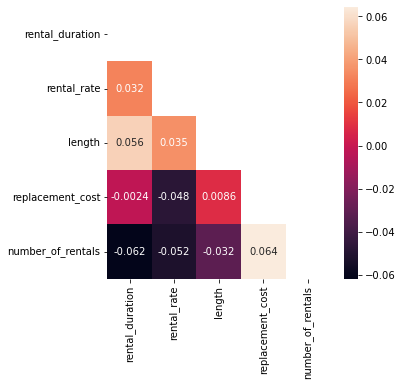

In [20]:
#HEATMAP
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.heatmap(data.corr(), mask=mask, annot=True)
plt.show()
# First observations
## Data that is negatively correlated to the number of rentals: length, rental_rate and rental_duration
## No high colinearity

In [21]:
# Encoding the categoricals
def get_dummies(df):
    cat = df.select_dtypes(object)
    dummyfied = pd.get_dummies(cat, columns=cat.columns, drop_first=True)
    return dummyfied

In [22]:
cat = get_dummies(data)
cat.head()

,title_ADAPTATION HOLES,title_AFFAIR PREJUDICE,title_AFRICAN EGG,title_AGENT TRUMAN,title_AIRPLANE SIERRA,title_AIRPORT POLLOCK,title_ALABAMA DEVIL,title_ALADDIN CALENDAR,title_ALAMO VIDEOTAPE,title_ALASKA PHANTOM,...,category_Sci-Fi,category_Sports,category_Travel,last_rental_date_2005-08-18,last_rental_date_2005-08-19,last_rental_date_2005-08-20,last_rental_date_2005-08-21,last_rental_date_2005-08-22,last_rental_date_2005-08-23,last_rental_date_2006-02-14
film_id,,,,,,,,,,,,,,,,,,,,,
103,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
738,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
331,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
382,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
489,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [23]:
# Isolating the numerical data
num = data.select_dtypes(np.number)
num.head()

,rental_duration,rental_rate,length,replacement_cost,number_of_rentals
film_id,,,,,
103,7,4.99,133,27.99,34
738,3,0.99,178,27.99,33
331,6,2.99,90,25.99,32
382,3,0.99,137,21.99,32
489,4,0.99,54,14.99,32


C:\Users\camil\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


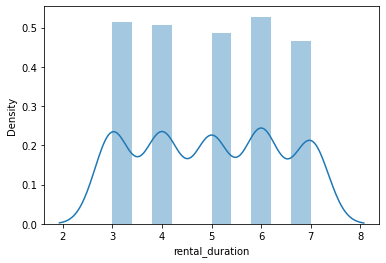

C:\Users\camil\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


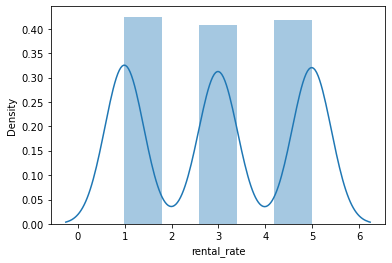

C:\Users\camil\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


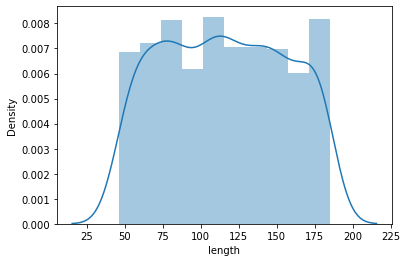

C:\Users\camil\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


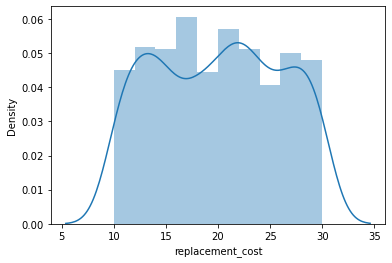

C:\Users\camil\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


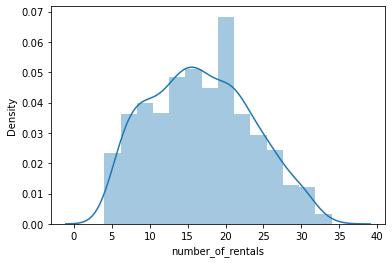

In [24]:
for column in num.columns:
    sns.distplot(data[column])
    plt.show()

## Normalizing the Data

In [25]:
transformer = StandardScaler().fit(num)
num_normalized = transformer.transform(num)
x = pd.DataFrame(num_normalized)
x.columns = num.columns
x.head()

,rental_duration,rental_rate,length,replacement_cost,number_of_rentals
0,1.443540,1.224470,0.431990,1.308771,2.586367
1,-1.398986,-1.211741,1.544183,1.308771,2.436513
2,0.732908,0.006364,-0.630772,0.978733,2.286658
3,-1.398986,-1.211741,0.530852,0.318657,2.286658
4,-0.688355,-1.211741,-1.520527,-0.836475,2.286658


In [26]:
x.reset_index(drop=True, inplace=True)
cat.reset_index(drop=True, inplace=True)
df = pd.concat([x, cat], axis=1)
df.shape

(957, 987)

## Creating the target variable

In [27]:
# Create a query to get the list of films and a boolean indicating if it was rented last month. 
# This would be our target variable.

In [28]:
target_query = '''
SELECT film_id,
	CASE
	WHEN MAX(last_rental_date) > '2006-01-31' THEN True
	ELSE False
		END AS rented_last_month
FROM 
	last_rental_date
GROUP BY
	film_id;
'''
target = pd.read_sql_query(target_query, engine)
target.head()

,film_id,rented_last_month
0,2,1
1,3,0
2,4,1
3,5,1
4,6,0


In [29]:
target.shape

(957, 2)

In [30]:
data.shape

(957, 9)

In [31]:
target.rented_last_month.value_counts()

0    789
1    168
Name: rented_last_month, dtype: int64

In [32]:
target['rented_last_month'] = target['rented_last_month'].astype('bool')

In [33]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   film_id            957 non-null    int64
 1   rented_last_month  957 non-null    bool 
dtypes: bool(1), int64(1)
memory usage: 8.5 KB


## Splitting the target and training the model

In [34]:
y = target['rented_last_month']
X = np.concatenate((x, cat), axis=1)

In [35]:
X.shape

(957, 987)

In [36]:
# We separate training and testing datasets and correspondant targets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [37]:
# Set and fit the model
logreg = LogisticRegression(random_state=0, multi_class='auto').fit(X_train, y_train)

In [38]:
# We predict on the testing dataset
y_pred_class = logreg.predict(X_test)

## Evaluating the Model

In [39]:
pd.Series(y_pred_class).value_counts()

False    288
dtype: int64

In [40]:
y_test.value_counts()
# our model looks like it can better predict the False values than the True values

False    234
True      54
Name: rented_last_month, dtype: int64

In [41]:
confusion_matrix(y_test, y_pred_class)

array([[234,   0],
       [ 54,   0]], dtype=int64)

In [42]:
confusion = confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

###### Classification Accuracy: Overall, how often is the classifier correct?

In [43]:
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

0.8125
0.8125


###### Sensitivity: When the actual value is positive, how often is the prediction correct?

In [44]:
sensitivity = TP / float(FN + TP)

print(sensitivity)
print(metrics.recall_score(y_test, y_pred_class))

0.0
0.0


###### False Negative Rate: When the actual value is positive, how often is the prediction incorrect?

In [45]:
false_negative_rate = FN / float( FN + TP)

print(false_negative_rate)
print(1 - sensitivity)

1.0
1.0


###### Specificity: When the actual value is negative, how often is the prediction correct?

In [46]:
specificity = TN / (TN + FP)

print(specificity)

1.0


###### False Positive Rate: When the actual value is negative, how often is the prediction incorrect?

In [47]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

0.0
0.0


C:\Users\camil\AppData\Local\Temp/ipykernel_9108/3168716342.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.subplot().xaxis.set_ticklabels(["1","0"])
C:\Users\camil\AppData\Local\Temp/ipykernel_9108/3168716342.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.subplot().yaxis.set_ticklabels(["1","0"])


[Text(0, 0.0, '1'),
 Text(0, 0.2, '0'),
 Text(0, 0.4, ''),
 Text(0, 0.6000000000000001, ''),
 Text(0, 0.8, ''),
 Text(0, 1.0, '')]

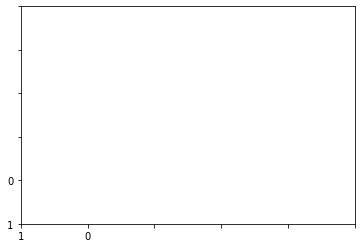

In [48]:
cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True,fmt='g')
plt.subplot().xaxis.set_ticklabels(["1","0"])
plt.subplot().yaxis.set_ticklabels(["1","0"])

In [49]:
# Accuracy
logreg.score(X_test, y_test)

0.8125

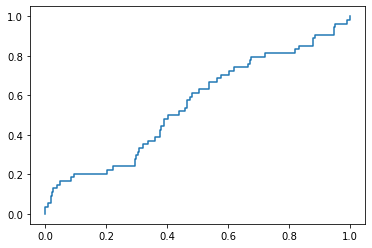

In [50]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr)

## Improving the Model
### We need to increase the sensitivity to increase the number of true positives

###### Remarks and notes

We are very bad at predicting one class - positives - and very good at predicting another - negatives - which is due to a data imbalance as we have 789 0s and 168 1s.
So we are very good with specificity and very bad at sensitivity.

### Taking the SMOTE approach

In [51]:
X_smote = df
y_smote = y

os = SMOTE(random_state=0)
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=0)
columns = X_smote_train.columns

os_data_X,os_data_y=os.fit_sample(X_smote_train, y_smote_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['rented_last_month'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of not rented in oversampled data",len(os_data_y[os_data_y['rented_last_month']==0]))
print("Number of rented",len(os_data_y[os_data_y['rented_last_month']==1]))
print("Proportion of not rented data in oversampled data is ",len(os_data_y[os_data_y['rented_last_month']==0])/len(os_data_X))
print("Proportion of rented data in oversampled data is ",len(os_data_y[os_data_y['rented_last_month']==1])/len(os_data_X))

length of oversampled data is  1098
Number of not rented in oversampled data 549
Number of rented 549
Proportion of not rented data in oversampled data is  0.5
Proportion of rented data in oversampled data is  0.5


In [52]:
os_data_X

,rental_duration,rental_rate,length,replacement_cost,number_of_rentals,title_ADAPTATION HOLES,title_AFFAIR PREJUDICE,title_AFRICAN EGG,title_AGENT TRUMAN,title_AIRPLANE SIERRA,...,category_Sci-Fi,category_Sports,category_Travel,last_rental_date_2005-08-18,last_rental_date_2005-08-19,last_rental_date_2005-08-20,last_rental_date_2005-08-21,last_rental_date_2005-08-22,last_rental_date_2005-08-23,last_rental_date_2006-02-14
0,0.732908,0.006364,-0.606057,0.813714,1.687238,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1.443540,1.224470,-1.125080,1.308771,-0.111021,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0.022277,-1.211741,1.025160,0.318657,0.338544,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1.443540,0.006364,0.506136,-0.836475,0.488399,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1.443540,0.006364,1.272314,0.153638,1.237673,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1093,0.578138,-1.211741,0.278719,-0.482478,1.120456,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1094,0.732908,-0.367408,-1.407312,0.763078,-0.030963,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1095,0.313846,0.365526,0.768483,-0.195450,-0.454916,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1096,-0.551821,1.224470,1.106486,0.518628,-1.609570,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
os_data_y

,rented_last_month
0,False
1,True
2,False
3,False
4,False
...,...
1093,True
1094,True
1095,True
1096,True


In [54]:
yf = os_data_y['rented_last_month']
yf

0       False
1        True
2       False
3       False
4       False
        ...  
1093     True
1094     True
1095     True
1096     True
1097     True
Name: rented_last_month, Length: 1098, dtype: bool

In [55]:
# Running the model with the SMOTEd data
Xf_train, Xf_test, yf_train, yf_test = train_test_split(os_data_X, yf, test_size=0.3, random_state=100)
logreg = LogisticRegression(random_state=0, multi_class='auto').fit(Xf_train, yf_train)
yf_pred_class = logreg.predict(Xf_test)

In [56]:
pd.Series(yf_pred_class).value_counts()

False    190
True     140
dtype: int64

In [57]:
yf.value_counts()

False    549
True     549
Name: rented_last_month, dtype: int64

In [58]:
confusion_matrix(yf_test, yf_pred_class)

array([[147,  18],
       [ 43, 122]], dtype=int64)

In [59]:
confusion_f = confusion_matrix(yf_test, yf_pred_class)
TP = confusion_f[1, 1]
TN = confusion_f[0, 0]
FP = confusion_f[0, 1]
FN = confusion_f[1, 0]

In [60]:
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(yf_test, yf_pred_class))

0.8151515151515152
0.8151515151515152


In [61]:
sensitivity_f = TP / float(FN + TP)

print(sensitivity_f)
print(metrics.recall_score(yf_test, yf_pred_class))

0.7393939393939394
0.7393939393939394


In [62]:
false_negative_rate_f = FN / float( FN + TP)

print(false_negative_rate_f)
print(1 - sensitivity_f)

0.2606060606060606
0.2606060606060606


In [63]:
specificity_f = TN / (TN + FP)

print(specificity_f)

0.8909090909090909


In [64]:
false_positive_rate_f = FP / float(TN + FP)

print(false_positive_rate_f)
print(1 - specificity_f)

0.10909090909090909
0.10909090909090913


C:\Users\camil\AppData\Local\Temp/ipykernel_9108/1749283728.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.subplot().xaxis.set_ticklabels(["1","0"])
C:\Users\camil\AppData\Local\Temp/ipykernel_9108/1749283728.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.subplot().yaxis.set_ticklabels(["1","0"])


[Text(0, 0.0, '1'),
 Text(0, 0.2, '0'),
 Text(0, 0.4, ''),
 Text(0, 0.6000000000000001, ''),
 Text(0, 0.8, ''),
 Text(0, 1.0, '')]

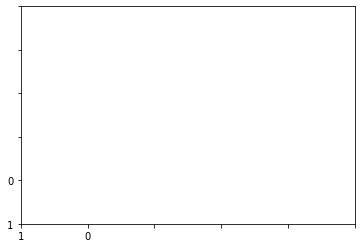

In [65]:
cm_f = confusion_matrix(yf_test, yf_pred_class)
sns.heatmap(cm_f, annot=True,fmt='g')
plt.subplot().xaxis.set_ticklabels(["1","0"])
plt.subplot().yaxis.set_ticklabels(["1","0"])

In [66]:
# Accuracy
logreg.score(Xf_test, yf_test)

0.8151515151515152

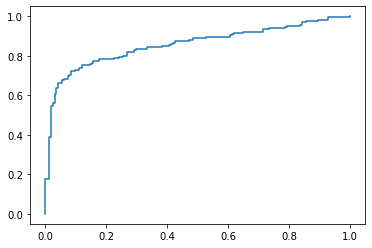

In [67]:
yf_pred_proba = logreg.predict_proba(Xf_test)[::,1]
fpr_f, tpr_f, _ = metrics.roc_curve(yf_test, yf_pred_proba)
auc_f = metrics.roc_auc_score(yf_test, yf_pred_proba)
plt.plot(fpr_f,tpr_f)